<div style="text-align: center; font-weight: bold;">
    <h1>Generating Research Ready EHR Datasets</h1>
    <h2>Part 2: Cleaning, Organizing and Rolling Up EHR Data</h2>
    <h4>Author: Vidul Ayakulangara Panickan</h3>
</div>



## Step 3: Cleaning the Data!

EHR cleaning involves several steps:  

> 1. Identifying and handling missing entries
> 2. Extracting only the columns of interest
> 3. Data Transformation
> 4. Reformatting columns
> 5. Identifying records with erroneous dates
> 6. Removing redundant information

In [1]:
# Importing required libraries.

import os
import sys
import time
import logging
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from IPython.display import display

# Set pandas options to expand all data within rows
pd.set_option('display.max_columns', None)      
pd.set_option('display.max_colwidth', None) 

In [2]:
# Setting up Directory to save Cleaned Data

base_directory = os.path.dirname(os.getcwd())
cleaned_rawdata_directory = os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata')
os.makedirs(cleaned_rawdata_directory, exist_ok=True)

print(f"Directory created at: {cleaned_rawdata_directory}")

Directory created at: /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/step3_cleaned_rawdata


### Cleaning Diagnoses Data as an example
First we will clean the diagnosis data to give an example of the steps involded and the order they are run. Then, we'll define these steps under a function and reuse them like we did in part 1 notebook.

In [5]:
# The diagnosis data is available in diagnoses_icd_file and the time of recording is available in admissions_file

base_directory = os.path.dirname(os.getcwd())
diagnoses_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","diagnoses_icd.csv")
admissions_file  = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","admissions.csv")

diagnoses_icd = pd.read_csv(diagnoses_icd_file, dtype=str)
admissions = pd.read_csv(admissions_file, dtype=str)

# Listing all columns
display(diagnoses_icd.columns)
display(admissions.columns)

Index(['subject_id', 'hadm_id', 'seq_num', 'icd_code', 'icd_version'], dtype='object')

Index(['subject_id', 'hadm_id', 'admittime', 'dischtime', 'deathtime',
       'admission_type', 'admit_provider_id', 'admission_location',
       'discharge_location', 'insurance', 'language', 'marital_status', 'race',
       'edregtime', 'edouttime', 'hospital_expire_flag'],
      dtype='object')

In [6]:
# Now before combining the tables, we need to check for missing data in raw files.

print("Diagnoses Table - Missing Values Count")
diagnoses_icd_missing_df = pd.DataFrame({'Column': diagnoses_icd.columns,'Missing_Values': diagnoses_icd.isna().sum()})
display(diagnoses_icd_missing_df)

print("Admissions Table - Missing Values Count")
admissions_missing_df = pd.DataFrame({'Column': admissions.columns,'Missing_Values': admissions.isna().sum()})
display(admissions_missing_df )

Diagnoses Table - Missing Values Count


,Column,Missing_Values
subject_id,subject_id,0
hadm_id,hadm_id,0
seq_num,seq_num,0
icd_code,icd_code,0
icd_version,icd_version,0


Admissions Table - Missing Values Count


,Column,Missing_Values
subject_id,subject_id,0
hadm_id,hadm_id,0
admittime,admittime,0
dischtime,dischtime,0
deathtime,deathtime,534238
admission_type,admission_type,0
admit_provider_id,admit_provider_id,4
admission_location,admission_location,1
discharge_location,discharge_location,149818
insurance,insurance,9355


### Keeping only the Required Columns

We only require the subject ID, hadm_id, and admittime from the admissions table to create the timestamped diagnosis dataset. And as there are no missing values, we can proceed with joining the tables.

Note: If any rows have missing dates or ICD codes, you can either remove them or impute them. When you have large enough data, it's common pracitce to remove rows if the number of missing values is low

In [7]:
# Merging diagnoses_icd and admissions tables on 'subject_id' and 'hadm_id' columns

diagnoses_icd = pd.read_csv(diagnoses_icd_file, dtype=str)
admissions = pd.read_csv(admissions_file, dtype=str)
timed_diagnoses_icd = pd.merge(
    diagnoses_icd,
    admissions[["subject_id", "hadm_id", "admittime"]],
    how="left",
    on=["subject_id", "hadm_id"],
)


display(timed_diagnoses_icd.head())

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime
0,10000032,22595853,1,5723,9,2180-05-06 22:23:00
1,10000032,22595853,2,78959,9,2180-05-06 22:23:00
2,10000032,22595853,3,5715,9,2180-05-06 22:23:00
3,10000032,22595853,4,07070,9,2180-05-06 22:23:00
4,10000032,22595853,5,496,9,2180-05-06 22:23:00


After a merge operation, it's vital to check whether the resulting table has any missing values. If there are a significant number of 
missing values, you should investigate further to identify underlying cause. For example, the join columns might be of different data types (like 'subject_id' can be integer in one table and string in another table), which can cause the join operation to essentially fail.


In [8]:
admissions_missing_df = pd.DataFrame({'Column': timed_diagnoses_icd.columns,'Missing_Values': timed_diagnoses_icd.isna().sum()})
display(admissions_missing_df)

,Column,Missing_Values
subject_id,subject_id,0
hadm_id,hadm_id,0
seq_num,seq_num,0
icd_code,icd_code,0
icd_version,icd_version,0
admittime,admittime,0


In [9]:
# Check columns of interest. If you have records where dates, icd_code or subect_ids are null, remove them. 

print(f"Table shape before null records have been removed {timed_diagnoses_icd.shape}")

timed_diagnoses_icd.dropna(subset=['admittime', 'icd_code', 'icd_version', 'subject_id'], how="any", inplace=True)

print(f"Table shape after null records have been removed {timed_diagnoses_icd.shape}")

Table shape before null records have been removed (6364488, 6)
Table shape after null records have been removed (6364488, 6)


### Data Transformation.
Here we truncate date to just the date to make them consisten with other dataset like procedure. 

In [10]:
# Removing the time component from the 'admittime' column to keep only the date (YYYY-MM-DD). This is typically done in cases where only the
# date component is relevant for the analysis.

timed_diagnoses_icd["admittime"] = timed_diagnoses_icd["admittime"].str[:10]

display(timed_diagnoses_icd.head())

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime
0,10000032,22595853,1,5723,9,2180-05-06
1,10000032,22595853,2,78959,9,2180-05-06
2,10000032,22595853,3,5715,9,2180-05-06
3,10000032,22595853,4,07070,9,2180-05-06
4,10000032,22595853,5,496,9,2180-05-06


In [11]:
# For diagnosis, we'll keep 'subject_id', 'icd_code', 'icd_version', and 'admittime'.You can retain other cols as needed for your analysis.

timed_diagnoses_icd=timed_diagnoses_icd[['subject_id','icd_code','icd_version','admittime']]

# Cleaning dataset also involves, renaming and restructing to ensure the newly generated datasets are consistent.
# Here we rename 'admittime' to 'date' to ensure consistency with other datasets that will be created later for meds, labs and procedures.

timed_diagnoses_icd = timed_diagnoses_icd.rename(columns={'admittime': 'date'})
display(timed_diagnoses_icd.head(5))

,subject_id,icd_code,icd_version,date
0,10000032,5723,9,2180-05-06
1,10000032,78959,9,2180-05-06
2,10000032,5715,9,2180-05-06
3,10000032,07070,9,2180-05-06
4,10000032,496,9,2180-05-06


#### Define a date range for the data (Not applicable to MIMIC-IV).

While MIMIC-IV uses adjusted dates, it’s important to ensure that dates in real-world datasets are reasonable. We will filter out records with dates that fall outside a specified range, such as those before the 1980s or after the current year. The code for this operation is provided below. However, for MIMIC-IV, since the dates are already adjusted, this cleaning step will not be applied.

In [ ]:
# diagnoses_icd = diagnoses_icd[
#     (diagnoses_icd["date"].str[:4].astype(int) >= 1980)
#     & (diagnoses_icd["date"].str[:4].astype(int) <= 2024)
# ]

In [13]:
# Check for duplicated rows in your data

if timed_diagnoses_icd.duplicated().sum() > 0:
    
    initial_row_count=timed_diagnoses_icd.shape[0]
    
    print(f"Initial table size {initial_row_count}")
    print("Duplicate rows found. Removing duplicates :")
    
    timed_diagnoses_icd = timed_diagnoses_icd.drop_duplicates()  # Remove duplicate rows
    final_row_count=timed_diagnoses_icd.shape[0]
    
    print(f"Records deleted: {initial_row_count - final_row_count}")
    print(f"Table size after removing duplicates : {final_row_count}")

else:
    print("No duplicate rows found.")

No duplicate rows found.


## Defining Cleaning Functions 

timed_diagnoses_icd now contains the cleaned ICD diagnoses data. Next, we will define the cleaning functions based on the code above, so they can be reused for other datasets

In [14]:
## Ignore the function below, we are defining functions so that we can print and save the info in a log file

import os
import sys
import time
import logging
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from IPython.display import display

# Set pandas options to expand all data within rows
pd.set_option('display.max_columns', None)      
pd.set_option('display.max_colwidth', None) 


def setup_logger(log_type,log_file):

    log_folder = os.path.join("log_folder", log_type)
    
    # Ensure the log folder exists
    os.makedirs(log_folder, exist_ok=True)
    
    # Define the full path for the log file
    log_filepath = os.path.join(log_folder, log_file)

    # Delete the log file if it exists
    if os.path.exists(log_filepath):
        os.remove(log_filepath)
    
    for handler in logging.root.handlers[:]:
        logging.root.removeHandler(handler)

    logging.basicConfig(level=logging.DEBUG, format='%(message)s', handlers=[logging.FileHandler(log_filepath)])

# Define the function to print and log messages
def print_and_log_cleaning(message):
    logging.info(message)     



def missing_values_summary(df):
    missing_values = df.isna().sum()
    missing_df = pd.DataFrame({'Column Name': missing_values.index, 'Missing Values Count': missing_values.values})
    print_and_log_cleaning("Missing Values Count:")
    print_and_log_cleaning(missing_df)



def clean_data(df, cols_of_interest, time_col):

    missing_values_summary(df)

    print_and_log_cleaning(f"Initial number of rows: {df.shape[0]}")

    print_and_log_cleaning("Keeping only the essential columns")
    df = df[cols_of_interest]

    if df.isna().sum().any():
        df = df.dropna()
        print_and_log_cleaning(f"Number of rows after dropping na rows: {df.shape[0]}")
    else:
        print_and_log_cleaning("No rows with missing values to drop.")

    print_and_log_cleaning("Extracting only the date info")
    df[time_col] = df[time_col].str[:10]

    print_and_log_cleaning("Renaming the columns")
    df = df.rename(columns={time_col: "date"})

    print_and_log_cleaning("Checking for duplicate rows")
    if df.duplicated().sum() > 0:
        print_and_log_cleaning("Duplicate rows found. Removing duplicates:")
        df = df.drop_duplicates()
        return df
    else:
        print_and_log_cleaning("No duplicate rows found.")
        return df


def clean_data_batch_supportfunc(df, cols_of_interest):

    missing_values_summary(df)

    print_and_log_cleaning(f"Initial number of rows: {df.shape[0]}")

    if df.isna().sum().any():
        df.dropna(inplace=True)
        print_and_log_cleaning(f"Number of rows after dropping na rows: {df.shape[0]}")
    else:
        print_and_log_cleaning("No rows with missing values to drop.")

    print_and_log_cleaning("Extracting only the date info")
    df[cols_of_interest['date']] = df[cols_of_interest['date']].str[:10]
  

    print_and_log_cleaning("Renaming the columns")
    df = df.rename(columns={cols_of_interest['date']: "date"})
    df = df.rename(columns={cols_of_interest['code']: "code"})

    print_and_log_cleaning("Checking for duplicate rows")
    if df.duplicated().sum() > 0:
        print_and_log_cleaning("Duplicate rows found. Removing duplicates:")
        df = df.drop_duplicates()
        return df
    else:
        print_and_log_cleaning("No duplicate rows found.")
        return df


def file_line_count(file_path):
    count = 0
    with open(file_path, 'r') as file:
        for line in file:
            count += 1
    return count


def clean_data_by_batch(input_file_path, cleaned_output_dir ,patient_ids, cols_of_interest, data_name, num_rows_to_load=1500000):
    #Coding system will be a list of columns if the coding system is defined in the input data, if not, you can pass a single value list

    filename = os.path.splitext(os.path.basename(input_file_path))[0]

    # Set up logger for cleaning function
    setup_logger("cleaning",f"{data_name}_{filename}.txt")  # Create log folder if necessary and set up logging

 
    # Create a dictionary for batch_num lookup based on subject_id
    batch_lookup = dict(zip(patient_ids['subject_id'], patient_ids['batch_num']))
    
    # Get the list of unique batch numbers from patient_ids
    unique_batch_nums = patient_ids['batch_num'].unique()

    output_dir = f'{cleaned_output_dir}/{data_name}'
    os.makedirs(output_dir, exist_ok=True)

    # Iterate over each batch number
    for batch_num in tqdm(unique_batch_nums, desc="Processing batches", unit="batch"):
        
        print_and_log_cleaning(f"\nProcessing batch {batch_num}:")

        collected_data = []

        non_none_cols_of_interest = [item for key, item in cols_of_interest.items() if item is not None and key != "coding_system"
]
        
        chunk_iter = pd.read_csv(input_file_path, chunksize=num_rows_to_load, usecols=non_none_cols_of_interest , dtype=str)
        
        # Process each chunk and collect data for the current batch
        for chunk_idx, chunk in enumerate(chunk_iter):
            print_and_log_cleaning(f"------ Processing  batch {batch_num} chunk{chunk_idx + 1}")

            batch_data = chunk[chunk['subject_id'].map(batch_lookup) == batch_num]
            
            if not batch_data.empty:
                collected_data.append(batch_data)
        
        # If we found data for this batch, clean and save it
        if collected_data:

            final_batch_data = pd.concat(collected_data, ignore_index=True)

            print_and_log_cleaning(final_batch_data)

            if cols_of_interest.get('code_version'):
                cleaned_batch_data = clean_data_batch_supportfunc(final_batch_data, cols_of_interest)
                cleaned_batch_data['coding_system'] = cols_of_interest['coding_system'] + cleaned_batch_data[cols_of_interest['code_version']]

                
            else:
                cleaned_batch_data = clean_data_batch_supportfunc(final_batch_data, cols_of_interest)
                cleaned_batch_data['coding_system'] = cols_of_interest['coding_system']

            cleaned_batch_data=cleaned_batch_data[['subject_id','date','code','coding_system']]
            
            # Prepare the output file path dynamically using the data_name and batch_num
            output_file = os.path.join(output_dir, f"{data_name.lower()}_batch{batch_num}_{filename}.csv")

            
            # Save the cleaned data to the file
            cleaned_batch_data.to_csv(output_file, index=False)

            clear_output(wait=True)
            display(cleaned_batch_data.head())
            print_and_log_cleaning(f"Batch {batch_num} cleaned data saved to {output_file}.")
        else:
            print_and_log_cleaning(f"Warning: No data found for batch {batch_num}.")
 
    
    
    display(f"\nCleaning complete. All batches processed and saved in the '{output_dir}' directory.")

## Handling Large-Scale Data
In real world data, EHR datasets are typically too large to load in the memory at once so we process them in batches.


In [15]:
# First we need to identify the individual patients and then we are gonna assign them to batches. If you do not have admissions file, 
# you can simply take the diagnosis file to get the unique patient ids.

base_directory = os.path.dirname(os.getcwd())
admissions_file  = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","admissions.csv")

admissions = pd.read_csv(admissions_file, dtype=str)
display(admissions.head(5))

# Getting unique patient ids and sorting them
patient_ids = admissions[['subject_id']].drop_duplicates()
patient_ids = patient_ids.sort_values(by='subject_id', ascending=True)
patient_ids = patient_ids.reset_index(drop=True)
display(patient_ids.head())

# specify the number of batches you want to have. The larger the data, the more batches you need to have
num_of_batches = 8

# Assigning batch number from 1 to 8
patient_ids['batch_num'] = (patient_ids.index % num_of_batches) + 1
display(patient_ids)

patient_count_per_batch = patient_ids.groupby('batch_num')['subject_id'].count().reset_index().rename(columns={'subject_id': 'patient_count'})
display(patient_count_per_batch)

,subject_id,hadm_id,admittime,dischtime,deathtime,admission_type,admit_provider_id,admission_location,discharge_location,insurance,language,marital_status,race,edregtime,edouttime,hospital_expire_flag
0,10000032,22595853,2180-05-06 22:23:00,2180-05-07 17:15:00,NaN,URGENT,P49AFC,TRANSFER FROM HOSPITAL,HOME,Medicaid,English,WIDOWED,WHITE,2180-05-06 19:17:00,2180-05-06 23:30:00,0
1,10000032,22841357,2180-06-26 18:27:00,2180-06-27 18:49:00,NaN,EW EMER.,P784FA,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-06-26 15:54:00,2180-06-26 21:31:00,0
2,10000032,25742920,2180-08-05 23:44:00,2180-08-07 17:50:00,NaN,EW EMER.,P19UTS,EMERGENCY ROOM,HOSPICE,Medicaid,English,WIDOWED,WHITE,2180-08-05 20:58:00,2180-08-06 01:44:00,0
3,10000032,29079034,2180-07-23 12:35:00,2180-07-25 17:55:00,NaN,EW EMER.,P06OTX,EMERGENCY ROOM,HOME,Medicaid,English,WIDOWED,WHITE,2180-07-23 05:54:00,2180-07-23 14:00:00,0
4,10000068,25022803,2160-03-03 23:16:00,2160-03-04 06:26:00,NaN,EU OBSERVATION,P39NWO,EMERGENCY ROOM,NaN,NaN,English,SINGLE,WHITE,2160-03-03 21:55:00,2160-03-04 06:26:00,0


,subject_id
0,10000032
1,10000068
2,10000084
3,10000108
4,10000117


,subject_id,batch_num
0,10000032,1
1,10000068,2
2,10000084,3
3,10000108,4
4,10000117,5
...,...,...
223447,19999733,8
223448,19999784,1
223449,19999828,2
223450,19999840,3


,batch_num,patient_count
0,1,27932
1,2,27932
2,3,27932
3,4,27932
4,5,27931
5,6,27931
6,7,27931
7,8,27931


### Cleaning Diagnoses Data

In [16]:
base_directory = os.path.dirname(os.getcwd())
diagnoses_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","diagnoses_icd.csv")
admissions_file  = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","admissions.csv")


diagnoses_icd = pd.read_csv(diagnoses_icd_file, dtype=str)
admissions = pd.read_csv(admissions_file, dtype=str)

timed_diagnoses_icd = pd.merge(
    diagnoses_icd,
    admissions[["subject_id", "hadm_id", "admittime"]],
    how="left",
    on=["subject_id", "hadm_id"],
)

display(timed_diagnoses_icd.head())

tmp_directory = os.path.join(base_directory, 'scripts', 'tmp')
print(f"Creating temp directory here {tmp_directory}")
os.makedirs(tmp_directory, exist_ok=True)

timed_diagnoses_icd_file = os.path.join(tmp_directory, f"timed_diagnoses_icd.csv")
timed_diagnoses_icd.to_csv(timed_diagnoses_icd_file, index=False)

,subject_id,hadm_id,seq_num,icd_code,icd_version,admittime
0,10000032,22595853,1,5723,9,2180-05-06 22:23:00
1,10000032,22595853,2,78959,9,2180-05-06 22:23:00
2,10000032,22595853,3,5715,9,2180-05-06 22:23:00
3,10000032,22595853,4,07070,9,2180-05-06 22:23:00
4,10000032,22595853,5,496,9,2180-05-06 22:23:00


Creating temp directory here /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/scripts/tmp


In [17]:
cols_of_interest = {
    "patient_id": "subject_id",
    "date": "admittime",
    "code": "icd_code",
    "code_version": "icd_version",
    "coding_system": "ICD"
}

clean_data_by_batch(
    timed_diagnoses_icd_file,
    cleaned_rawdata_directory,
    patient_ids,
    cols_of_interest,
    "Diagnoses",
    num_rows_to_load=15000000
)

,subject_id,date,code,coding_system
0,10000280,2151-03-18,6820,ICD9
1,10000886,2178-05-08,30500,ICD9
2,10001217,2157-11-18,3240,ICD9
3,10001217,2157-11-18,3484,ICD9
4,10001217,2157-11-18,3485,ICD9


Processing batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:53<00:00,  6.67s/batch]


"\nCleaning complete. All batches processed and saved in the '/n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/step3_cleaned_rawdata/Diagnoses' directory."

### Cleaning Procedures Data

In MIMIC Procedure data come from two sources: 
1. hcpcsevents.csv where procedures are recorded as CPT codes 
2. procedures_icd.csv where procedures are recorded as ICD9/ICD10 Procedure codes

We will need to clean them both and concatenate them.

In [22]:
# Cleaning HCPCS events
base_directory = os.path.dirname(os.getcwd())
hcpcsevents_file_path = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","hcpcsevents.csv")

hcpcsevents_sample = pd.read_csv(hcpcsevents_file_path ,nrows=5,dtype=str)
display(hcpcsevents_sample)

,subject_id,hadm_id,chartdate,hcpcs_cd,seq_num,short_description
0,10000068,25022803,2160-03-04,99218,1,Hospital observation services
1,10000084,29888819,2160-12-28,G0378,1,Hospital observation per hr
2,10000108,27250926,2163-09-27,99219,1,Hospital observation services
3,10000117,22927623,2181-11-15,43239,1,Digestive system
4,10000117,22927623,2181-11-15,G0378,2,Hospital observation per hr


In [23]:
cols_of_interest = {
    "patient_id": "subject_id",
    "date": "chartdate",
    "code": "hcpcs_cd",
    "code_version": None,
    "coding_system": "HCPCS"
}

clean_data_by_batch(
    hcpcsevents_file_path,
    cleaned_rawdata_directory,
    patient_ids,
    cols_of_interest,
    "Procedures",
    num_rows_to_load=15000000
)

,subject_id,date,code,coding_system
0,10000280,2151-03-18,99219,HCPCS
1,10000886,2178-05-08,99219,HCPCS
2,10002425,2153-01-07,27339,HCPCS
4,10002425,2153-01-07,G0378,HCPCS
5,10002807,2152-03-30,G0378,HCPCS


Processing batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:02<00:00,  3.09batch/s]


"\nCleaning complete. All batches processed and saved in the '/n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/step3_cleaned_rawdata/Procedures' directory."

In [24]:
# Cleaning procedures_icd.csv

base_directory = os.path.dirname(os.getcwd())
procedures_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","procedures_icd.csv")

procedures_icd_sample = pd.read_csv(procedures_icd_file, dtype=str, nrows=5)

display(procedures_icd_sample)

,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
0,10000032,22595853,1,2180-05-07,5491,9
1,10000032,22841357,1,2180-06-27,5491,9
2,10000032,25742920,1,2180-08-06,5491,9
3,10000068,25022803,1,2160-03-03,8938,9
4,10000117,27988844,1,2183-09-19,0QS734Z,10


In [21]:
cols_of_interest = {
    "patient_id": "subject_id",
    "date": "chartdate",
    "code": "icd_code",
    "code_version": "icd_version",
    "coding_system": "ICDPROC"
}

clean_data_by_batch(
    procedures_icd_file,
    cleaned_rawdata_directory,
    patient_ids,
    cols_of_interest,
    "Procedures",
    num_rows_to_load=15000000
)

,subject_id,date,code,coding_system
0,10000280,2151-03-18,8938,ICDPROC9
1,10000886,2178-05-08,8938,ICDPROC9
2,10001217,2157-11-20,0139,ICDPROC9
3,10001217,2157-11-19,0331,ICDPROC9
4,10001217,2157-11-22,3897,ICDPROC9


Processing batches: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:08<00:00,  1.00s/batch]


### Cleaning Medications Data

In [25]:
base_directory = os.path.dirname(os.getcwd())
prescriptions_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","prescriptions.csv")

# Loading the top 5 rows to identify columns of interest
prescriptions_sample = pd.read_csv(prescriptions_file,dtype=str,nrows=5)

display(prescriptions_sample)

,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,12775705,10000032-55,55,P85UQ1,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,FURO40,008209,51079007320,40mg Tablet,NaN,40,mg,1,TAB,1,PO/NG
1,10000032,22595853,18415984,10000032-42,42,P23SJA,2180-05-07 02:00:00,2180-05-07 22:00:00,MAIN,Ipratropium Bromide Neb,IPRA2H,021700,00487980125,2.5mL Vial,NaN,1,NEB,1,VIAL,4,IH
2,10000032,22595853,23637373,10000032-35,35,P23SJA,2180-05-07 01:00:00,2180-05-07 09:00:00,MAIN,Furosemide,FURO20,008208,51079007220,20mg Tablet,NaN,20,mg,1,TAB,1,PO/NG
3,10000032,22595853,26862314,10000032-41,41,P23SJA,2180-05-07 01:00:00,2180-05-07 01:00:00,MAIN,Potassium Chloride,MICROK10,001275,00245004101,10mEq ER Tablet,NaN,40,mEq,4,TAB,1,PO
4,10000032,22595853,30740602,10000032-27,27,P23SJA,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0,10 mL Syringe,NaN,3,mL,0.3,SYR,3,IV


In [26]:
cols_of_interest = {
    "patient_id": "subject_id",
    "date": "starttime",
    "code": "ndc",
    "code_version": None,
    "coding_system": "NDC"
}

clean_data_by_batch(
    prescriptions_file,
    cleaned_rawdata_directory,
    patient_ids,
    cols_of_interest,
    "Medication",
    num_rows_to_load=15000000
)

,subject_id,date,code,coding_system
0,10001217,2157-11-22,08290036005,NDC
1,10001217,2157-11-21,00641608025,NDC
2,10001217,2157-11-22,00338001702,NDC
3,10001217,2157-11-22,00409433201,NDC
4,10001217,2157-11-21,0,NDC


Processing batches: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [04:25<00:00, 33.22s/batch]


"\nCleaning complete. All batches processed and saved in the '/n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/step3_cleaned_rawdata/Medication' directory."

## Cleaning Lab Data: Handling Large-Scale Data

In [27]:
base_directory = os.path.dirname(os.getcwd())

labitems_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "labevents.csv")

labs_sample= pd.read_csv(labitems_file,dtype=str,nrows=5)

display(labs_sample)

,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,2704548,50931,P69FQC,2180-03-23 11:51:00,2180-03-23 15:56:00,___,95,mg/dL,70,100,NaN,ROUTINE,"IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DIABETES."
1,2,10000032,NaN,36092842,51071,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
2,3,10000032,NaN,36092842,51074,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
3,4,10000032,NaN,36092842,51075,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,"BENZODIAZEPINE IMMUNOASSAY SCREEN DOES NOT DETECT SOME DRUGS,;INCLUDING LORAZEPAM, CLONAZEPAM, AND FLUNITRAZEPAM."
4,5,10000032,NaN,36092842,51079,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN


In [28]:
# Counting the number of lines in the lab file

file_line_count(labitems_file)

158374765

Lab data is one of the largest subdatasets in EHR due to the high frequency of recorded lab events. In MIMIC-IV, there are over 158 million lab observations recorded and loading the entire dataset into memory at once is inefficient and may cause your program to crash. Therefore, we will process the data in batches, working with one batch of patients at a time

In [29]:
# This will take atleast 3-4 minutes to process a batch, and around 30 mins for the entire lab data

cols_of_interest = {
    "patient_id": "subject_id",
    "date": "charttime",
    "code": "itemid",
    "code_version": None,
    "coding_system": "ITEMID"
}

clean_data_by_batch(
    labitems_file,
    cleaned_rawdata_directory,
    patient_ids,
    cols_of_interest,
    "Labs",
    num_rows_to_load=15000000
)


# We process data in batches of patients, rather than batches of data, to efficiently handle duplicates, as we can't load the entire dataset into memory at once.
# If it takes too long to process a chunk, try reducing num_rows_to_load

,subject_id,date,code,coding_system
0,10000280,2151-03-18,51146,ITEMID
1,10000280,2151-03-18,51200,ITEMID
2,10000280,2151-03-18,51221,ITEMID
3,10000280,2151-03-18,51222,ITEMID
4,10000280,2151-03-18,51244,ITEMID


Processing batches: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [25:46<00:00, 193.25s/batch]


"\nCleaning complete. All batches processed and saved in the '/n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/step3_cleaned_rawdata/Labs' directory."

After running Step 3, you will have the following files generated under your workspace.

```bash
EHR_TUTORIAL_WORKSPACE/
└── processed_data/
    └── step3_cleaned_rawdata/
        ├── Diagnoses/
        │   ├── diagnoses_batch1_timed_diagnoses_icd.csv
        │   ├── diagnoses_batch2_timed_diagnoses_icd.csv
        │   ├── diagnoses_batch3_timed_diagnoses_icd.csv
        │   ├── diagnoses_batch4_timed_diagnoses_icd.csv
        │   ├── diagnoses_batch5_timed_diagnoses_icd.csv
        │   ├── diagnoses_batch6_timed_diagnoses_icd.csv
        │   ├── diagnoses_batch7_timed_diagnoses_icd.csv
        │   └── diagnoses_batch8_timed_diagnoses_icd.csv
        ├── Labs/
        │   ├── labs_batch1_labevents.csv
        │   ├── labs_batch2_labevents.csv
        │   ├── labs_batch3_labevents.csv
        │   ├── labs_batch4_labevents.csv
        │   ├── labs_batch5_labevents.csv
        │   ├── labs_batch6_labevents.csv
        │   ├── labs_batch7_labevents.csv
        │   └── labs_batch8_labevents.csv
        ├── Medication/
        │   ├── medication_batch1_prescriptions.csv
        │   ├── medication_batch2_prescriptions.csv
        │   ├── medication_batch3_prescriptions.csv
        │   ├── medication_batch4_prescriptions.csv
        │   ├── medication_batch5_prescriptions.csv
        │   ├── medication_batch6_prescriptions.csv
        │   ├── medication_batch7_prescriptions.csv
        │   └── medication_batch8_prescriptions.csv
        └── Procedures/
            ├── procedures_batch1_hcpcsevents.csv
            ├── procedures_batch2_hcpcsevents.csv
            ├── procedures_batch3_hcpcsevents.csv
            ├── procedures_batch4_hcpcsevents.csv
            ├── procedures_batch5_hcpcsevents.csv
            ├── procedures_batch6_hcpcsevents.csv
            ├── procedures_batch7_hcpcsevents.csv
            └── procedures_batch8_hcpcsevents.csv

```

## Step 4: Rolling up the Raw Data

For data to be effectively compared and analyzed, it must be standardized. For example, medical codes in electronic health records (EHR) like medications codes may come from different coding systems like NDC, RxNorm, or institution-specific local codes. "Rolling up" data from these various coding systems to a common parent coding system ensures standardization.

There are additional reasons to perform the rollup:

1. The raw EHR codes may be too specific, making analysis difficult or impractical.
2. Rolling up helps harmonize data across different institutions, enabling analysis on a larger scale.

In [2]:
import os
import sys
import time
import logging
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from IPython.display import display

# Set pandas options to expand all data within rows
pd.set_option('display.max_columns', None)      
pd.set_option('display.max_colwidth', None) 

# Setting up Directory to save Rolledup Data

base_directory = os.path.dirname(os.getcwd())

rolledup_intermediatedata_directory = os.path.join(base_directory, 'processed_data', 'step4_rolledup_intermediatedata')
os.makedirs(rolledup_intermediatedata_directory, exist_ok=True)
print(f"Directory created at: {rolledup_intermediatedata_directory}")

rolledup_finaldata_directory = os.path.join(base_directory, 'processed_data', 'step4_rolledup_finaldata')
os.makedirs(rolledup_finaldata_directory, exist_ok=True)
print(f"Directory created at: {rolledup_finaldata_directory}")


Directory created at: /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/step4_rolledup_intermediatedata
Directory created at: /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/step4_rolledup_finaldata


### Rolling up Diagnoses Data
ICD codes are too detailed to be used for research purposes. Phecodes solves this problem by grouping relevant ICD codes into clinical meaningful phenotypes.

- **Rolled up to**: PheCodes
Use resources like the [PheWAS Catalog](https://phewascatalog.org/) and the PheWAS hierarchy to map diagnosis codes (e.g., ICD-9/10) to PheCodes. Enables grouping related diagnoses into clinically meaningful categories.

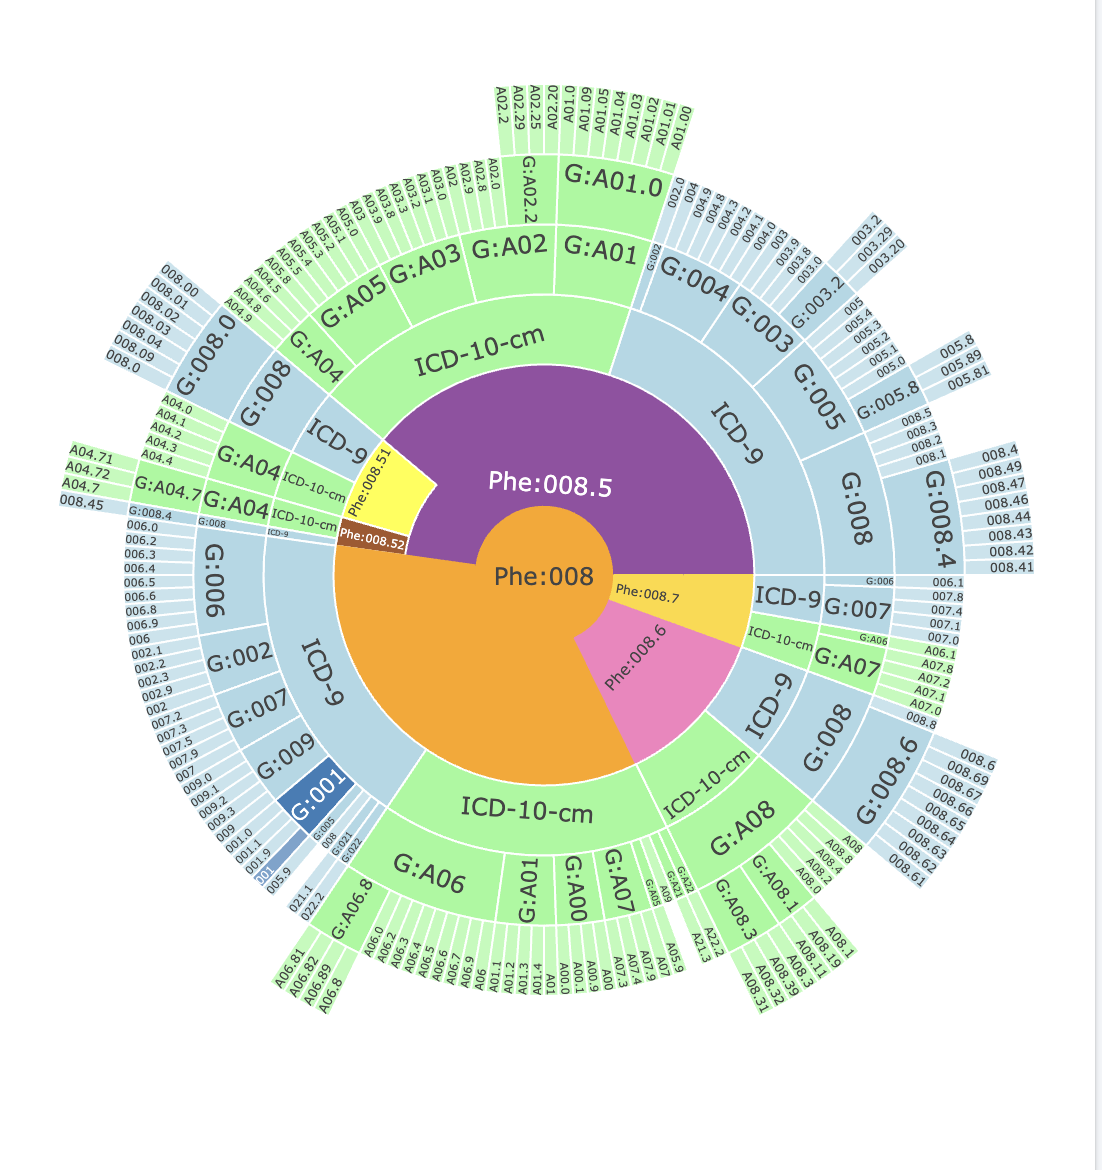

In [3]:
base_directory = os.path.dirname(os.getcwd())

icd_to_phecode_file = os.path.join(base_directory, 'scripts', 'rollup_mappings',"icd_to_phecode.csv")
icd_to_phecode = pd.read_csv(icd_to_phecode_file, dtype=str)
display(icd_to_phecode.head())

,code,PheCode,coding_system
0,001,008,ICD9
1,0010,008,ICD9
2,0011,008,ICD9
3,0019,008,ICD9
4,002,008,ICD9


In [4]:
# We will select a sample diagnoses file for rolling up

base_directory = os.path.dirname(os.getcwd())

diagnoses_cleaned_rawdata = os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata',"Diagnoses")
diagnoses_files = os.listdir(diagnoses_cleaned_rawdata)

sample_diagnoses_filepath= os.path.join(diagnoses_cleaned_rawdata, diagnoses_files[0])
sample_diagnoses = pd.read_csv(sample_diagnoses_filepath, dtype=str)
display(sample_diagnoses.head())

,subject_id,date,code,coding_system
0,10000032,2180-05-06,5723,ICD9
1,10000032,2180-05-06,78959,ICD9
2,10000032,2180-05-06,5715,ICD9
3,10000032,2180-05-06,07070,ICD9
4,10000032,2180-05-06,496,ICD9


Now, if you observe the rollup mapping file and the actual diagnoses file, you will notice a mismatch in the column names. To perform the
rollup using a join operation, you will need to make the column names consistent. You can do this by renaming the columns in the rollup file.

In [5]:
# Merging the two tables to rollup/map icd code to phecode. Save this rolled up data in intermediate folder. 
# In future if you update rollup mapping to be more comprehensive or if you want to look at codes that are unmapped, you can always come back.
    
sample_diagnoses_phecode = pd.merge(sample_diagnoses, icd_to_phecode, how='left', on=['code','coding_system'])

sample_diagnoses_phecode['Rollup_Status'] = sample_diagnoses_phecode['PheCode'].notna().replace({True: '1', False: '0'})

display(sample_diagnoses_phecode.head())
print(sample_diagnoses_phecode.shape)

,subject_id,date,code,coding_system,PheCode,Rollup_Status
0,10000032,2180-05-06,5723,ICD9,571.81,1
1,10000032,2180-05-06,78959,ICD9,572,1
2,10000032,2180-05-06,5715,ICD9,571.51,1
3,10000032,2180-05-06,07070,ICD9,070.3,1
4,10000032,2180-05-06,496,ICD9,496,1


(799778, 6)


In [6]:
# Unrolled rows (where ICD codes were not rolled up)

sample_diagnoses_unrolled = sample_diagnoses_phecode[sample_diagnoses_phecode["Rollup_Status"]=="0"]
display(sample_diagnoses_unrolled.head())
print(sample_diagnoses_unrolled.shape)

,subject_id,date,code,coding_system,PheCode,Rollup_Status
34,10000032,2180-07-23,V4986,ICD9,NaN,0
44,10001319,2135-07-20,V270,ICD9,NaN,0
46,10001319,2138-11-09,V270,ICD9,NaN,0
48,10001319,2134-04-15,V270,ICD9,NaN,0
52,10001843,2131-11-09,Y840,ICD10,NaN,0


(52416, 6)


In [7]:
# Summarize the codes that have not been rolledup

unique_subject_icd_pairs = sample_diagnoses_unrolled[['subject_id', 'code','coding_system']].drop_duplicates()

icdcode_frequencies = unique_subject_icd_pairs[['code','coding_system']].value_counts().reset_index(name='counts')

sorted_icdcode_frequencies = icdcode_frequencies.rename(columns={'index': 'code'}).sort_values(by='counts', ascending=False)

display(sorted_icdcode_frequencies.head(10))

,code,coding_system,counts
0,Z20822,ICD10,3009
1,Y929,ICD10,1956
2,Y92230,ICD10,1115
3,V270,ICD9,1086
4,V4986,ICD9,1057
5,Y92009,ICD10,901
6,Y92239,ICD10,898
7,E8497,ICD9,867
8,E8490,ICD9,743
9,E8788,ICD9,694


Once the data looks reasonable, with good enough rollup done, you can save the data. You can save the comprehensive data with rolled and unrolled info into the intermidate_data folder. You can come back to this if you need to check anything in the future. 

You can save the rolled up file under rolleddup_data

We don't really need all the columns after rollup is performed. Below we just keep the data we need.

In [8]:
sample_diagnoses_phecode_filtered = sample_diagnoses_phecode[sample_diagnoses_phecode['Rollup_Status']=="1"]

print(sample_diagnoses_phecode_filtered )
sample_diagnoses_phecode_filtered  = sample_diagnoses_phecode_filtered [['subject_id','PheCode','date']]
sample_diagnoses_phecode_filtered 

       subject_id        date    code coding_system PheCode Rollup_Status
0        10000032  2180-05-06    5723          ICD9  571.81             1
1        10000032  2180-05-06   78959          ICD9     572             1
2        10000032  2180-05-06    5715          ICD9  571.51             1
3        10000032  2180-05-06   07070          ICD9   070.3             1
4        10000032  2180-05-06     496          ICD9     496             1
...           ...         ...     ...           ...     ...           ...
799773   19999784  2121-01-31   Z5111         ICD10    1010             1
799774   19999784  2121-01-31   C8589         ICD10   202.2             1
799775   19999784  2121-01-31    E876         ICD10  276.14             1
799776   19999784  2121-01-31  Z87891         ICD10     318             1
799777   19999784  2121-01-31   Z8619         ICD10     136             1

[747362 rows x 6 columns]


,subject_id,PheCode,date
0,10000032,571.81,2180-05-06
1,10000032,572,2180-05-06
2,10000032,571.51,2180-05-06
3,10000032,070.3,2180-05-06
4,10000032,496,2180-05-06
...,...,...,...
799773,19999784,1010,2121-01-31
799774,19999784,202.2,2121-01-31
799775,19999784,276.14,2121-01-31
799776,19999784,318,2121-01-31


In [9]:
if sample_diagnoses_phecode_filtered.duplicated().sum() > 0:
    print("Duplicate rows found. Removing duplicates...")
    sample_diagnoses_phecode_filtered = sample_diagnoses_phecode_filtered.drop_duplicates()  # Remove duplicate rows
    print("DataFrame after removing duplicates:")
else:
    print("No duplicate rows found.")

display(sample_diagnoses_phecode_filtered)

Duplicate rows found. Removing duplicates...
DataFrame after removing duplicates:


,subject_id,PheCode,date
0,10000032,571.81,2180-05-06
1,10000032,572,2180-05-06
2,10000032,571.51,2180-05-06
3,10000032,070.3,2180-05-06
4,10000032,496,2180-05-06
...,...,...,...
799773,19999784,1010,2121-01-31
799774,19999784,202.2,2121-01-31
799775,19999784,276.14,2121-01-31
799776,19999784,318,2121-01-31


## Defining Functions 

As we will be perfoming operations similar to what we did to roll up ICD codes, its better to define these operations
as a function so we can resue them.

In [1]:
import os
import sys
import time
import logging
import pandas as pd
from tqdm import tqdm
from IPython.display import clear_output
from IPython.display import display

# Set pandas options to expand all data within rows
pd.set_option('display.max_columns', None)      
pd.set_option('display.max_colwidth', None) 

def rollup(raw_level_data, rollup_mapping , join_columns, parent_column):
    
    rolledup_data = pd.merge(raw_level_data, rollup_mapping, how='left', on=join_columns)
    
    rolledup_data['Rollup_Status'] = rolledup_data[parent_column].notna().replace({True: '1', False: '0'})
    
    return rolledup_data


def summarize_unmapped(rolledup_data, child_column):
    
    rolledup_data_unmapped = rolledup_data[rolledup_data["Rollup_Status"]=="0"]
    
    unique_patient_code_pairs = rolledup_data_unmapped[['subject_id', child_column]].drop_duplicates()

    unmapped_code_frequencies = unique_patient_code_pairs[[child_column]].value_counts().reset_index(name='counts')

    unmapped_code_frequencies = unmapped_code_frequencies.rename(columns={'index': child_column})
    
    return unmapped_code_frequencies


def filter_rolledup_data(rolledup_data,cols_of_interest):
    
    filtered = rolledup_data[rolledup_data['Rollup_Status']=="1"]
    
    filtered = filtered[cols_of_interest]

    filtered.drop_duplicates(inplace=True)
    
    return filtered
    

def rollup_data_by_batch(config, unrolled_data_folder):

    base_directory = os.path.dirname(os.getcwd())
    summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
    intermediate_dir = os.path.join(base_directory, 'processed_data', 'step4_rolledup_intermediatedata')
    rolledup_dir =  os.path.join(base_directory, 'processed_data', 'step4_rolledup_finaldata')


    folder_name = os.path.basename(unrolled_data_folder)
    intermediate_dir = f"{intermediate_dir}/{folder_name}"
    rolledup_dir = f"{rolledup_dir}/{folder_name}"
    
    unrolled_summary_dir = f"{summary_directory}/Unrolled_Summary"
    files = os.listdir(unrolled_data_folder)


    output_dir = f'{rolledup_dir}/{folder_name}'

    os.makedirs(intermediate_dir, exist_ok=True)
    os.makedirs(rolledup_dir, exist_ok=True)
    os.makedirs(unrolled_summary_dir, exist_ok=True)

    unrolled_freq_list = []

    batches = [file.split("_")[1] for file in files]
    unique_batches = set(batches)

    for batch in tqdm(unique_batches, desc="Processing batches", unit="batch"):
        load_files = [file for file in files if batch in file]
 

        if len(load_files)==1:
            filepath = os.path.join(unrolled_data_folder, load_files[0])
            file_df = pd.read_csv(filepath, dtype=str)
            
        else:
            df_list = []
            for file in load_files:
                filepath = os.path.join(unrolled_data_folder, file)
                df_list.append(pd.read_csv(filepath, dtype=str))
            file_df = pd.concat(df_list)

        
        intermediate_df = rollup(file_df, config["rollup_mapping"], [config['child_column'],"coding_system"], config['parent_column'])
        intermediate_file = os.path.join(intermediate_dir, f"intermediate_{batch}.csv")
        intermediate_df.to_csv(intermediate_file, index=False)
        
        unrolled_freq_list.append(summarize_unmapped(intermediate_df, config['child_column']))

        cols_of_interest = [config['patient_id'],config['date'],config['parent_column']]
        
        only_rolledup_df = filter_rolledup_data(intermediate_df, cols_of_interest)
        only_rolledup_filepath = os.path.join(rolledup_dir, f"rolledup_{batch}.csv")
        only_rolledup_df.to_csv(only_rolledup_filepath, index=False)

        clear_output(wait=True)
        display(only_rolledup_df)


    
    unrolled_summary_file = os.path.join(unrolled_summary_dir , "unrolled_" + folder_name + "_code_counts.csv")

    unrolled_summary =(
        pd.concat(unrolled_freq_list)  # Concatenate list of DataFrames
        .groupby(config['child_column'], as_index=False)["counts"]
        .sum()
        .sort_values(by="counts", ascending=False)
        )
    
    display(unrolled_summary)
    unrolled_summary.to_csv(unrolled_summary_file, index=False)


### Diagnosis Data


In [2]:
base_directory = os.path.dirname(os.getcwd())

diagnoses_cleaned_rawdata = os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata',"Diagnoses")
diagnoses_files = os.listdir(diagnoses_cleaned_rawdata)
sample_diagnoses_file= os.path.join(diagnoses_cleaned_rawdata, diagnoses_files[0])
sample_diagnoses_file = pd.read_csv(sample_diagnoses_file, dtype=str)
display(sample_diagnoses_file.head())

icd_to_phecode_file = os.path.join(base_directory, 'scripts', 'rollup_mappings',"icd_to_phecode.csv")
diagnoses_to_phecode = pd.read_csv(icd_to_phecode_file , dtype=str)
display(diagnoses_to_phecode.head())

,subject_id,date,code,coding_system
0,10000032,2180-05-06,5723,ICD9
1,10000032,2180-05-06,78959,ICD9
2,10000032,2180-05-06,5715,ICD9
3,10000032,2180-05-06,07070,ICD9
4,10000032,2180-05-06,496,ICD9


,code,PheCode,coding_system
0,001,008,ICD9
1,0010,008,ICD9
2,0011,008,ICD9
3,0019,008,ICD9
4,002,008,ICD9


In [3]:
config = {
    "patient_id":     "subject_id",
    "parent_column":  "PheCode",
    "child_column":   "code",
    "date":           "date",
    "rollup_mapping": diagnoses_to_phecode
}

rollup_data_by_batch(
    config,
    os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata','Diagnoses')
)

,subject_id,date,PheCode
0,10000161,2163-08-20,287.31
2,10000826,2146-12-05,317.11
3,10000826,2146-12-05,480
4,10000826,2146-12-05,572
5,10000826,2146-12-05,571.81
...,...,...,...
796977,19999287,2191-12-29,496
796978,19999287,2191-12-29,318
796980,19999287,2191-12-29,1013
796981,19999565,2185-06-04,800.2


Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:23<00:00,  2.97s/batch]


,code,counts
2461,Z20822,23629
2381,Y929,15945
2309,Y92230,9019
1335,V270,8375
1484,V4986,8006
...,...,...
1869,W12XXXS,1
1871,W130XXD,1
1872,W130XXS,1
860,Q9382,1


### Procedures Data

As mentioned before, procedure data comes from two sources: hcpcsevents.csv and procedures_icd.csv 
Our objective is to roll them both up to ccs code and merge them. 

In [4]:
# Rolling up procedure data
base_directory = os.path.dirname(os.getcwd())

procedure_cleaned_rawdata = os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata',"Procedures")
procedure_files = os.listdir(procedure_cleaned_rawdata)
sample_procedure_filepath= os.path.join(procedure_cleaned_rawdata, procedure_files[0])
sample_procedure = pd.read_csv(sample_procedure_filepath, dtype=str)
display(sample_procedure.head())


procedure_rollup_file = os.path.join(base_directory, 'scripts', 'rollup_mappings',"HCPCS_ICDPROC_to_CCS.csv")
procedure_to_ccs = pd.read_csv(procedure_rollup_file , dtype=str)

display(procedure_to_ccs.head())

,subject_id,date,code,coding_system
0,10000904,2180-10-09,99218,HCPCS
1,10002131,2123-06-25,G0378,HCPCS
2,10002428,2155-07-14,G0378,HCPCS
3,10002428,2160-07-15,G0378,HCPCS
4,10002428,2157-07-16,27235,HCPCS


,code,CCS,coding_system
0,00800ZZ,1,ICDPROC10
1,00803ZZ,1,ICDPROC10
2,00804ZZ,1,ICDPROC10
3,00870ZZ,1,ICDPROC10
4,00873ZZ,1,ICDPROC10


In [5]:
config={
    "patient_id":"subject_id",
    "parent_column":"CCS",
    "child_column":"code",
    "date":"date",
    "rollup_mapping":procedure_to_ccs
}

rollup_data_by_batch(
    config,
    os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata','Procedures')
)

,subject_id,date,CCS
0,10000161,2163-08-20,227
1,10001176,2186-11-29,227
2,10002012,2167-03-17,227
3,10002315,2161-03-23,227
4,10002800,2164-07-12,29
...,...,...,...
23042,19996432,2113-11-11,227
23043,19996432,2114-08-23,227
23044,19996432,2116-09-04,227
23045,19996832,2179-11-14,227


Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:01<00:00,  5.77batch/s]


,code,counts
107,92980,323
124,93545,273
74,43268,252
75,43269,196
76,43271,139
...,...,...
81,45339,1
84,47500,1
92,50392,1
96,61795,1


### Medication Data

In MIMIC Medications data come from two sources: 
1. prescriptions.csv where medications prescribed are recorded 
2. emar.csv where procedures are recorded as ndc codes - Hihgly granular information

Our objective is to map medication codes to RxNorm concepts at the ingredient level using the RxNorm hierarchy. This process facilitates the standardization of drugs across datasets. The following is an example of the RxNorm hierarchy, where branded drugs and combination drugs are rolled up to their individual ingredients.

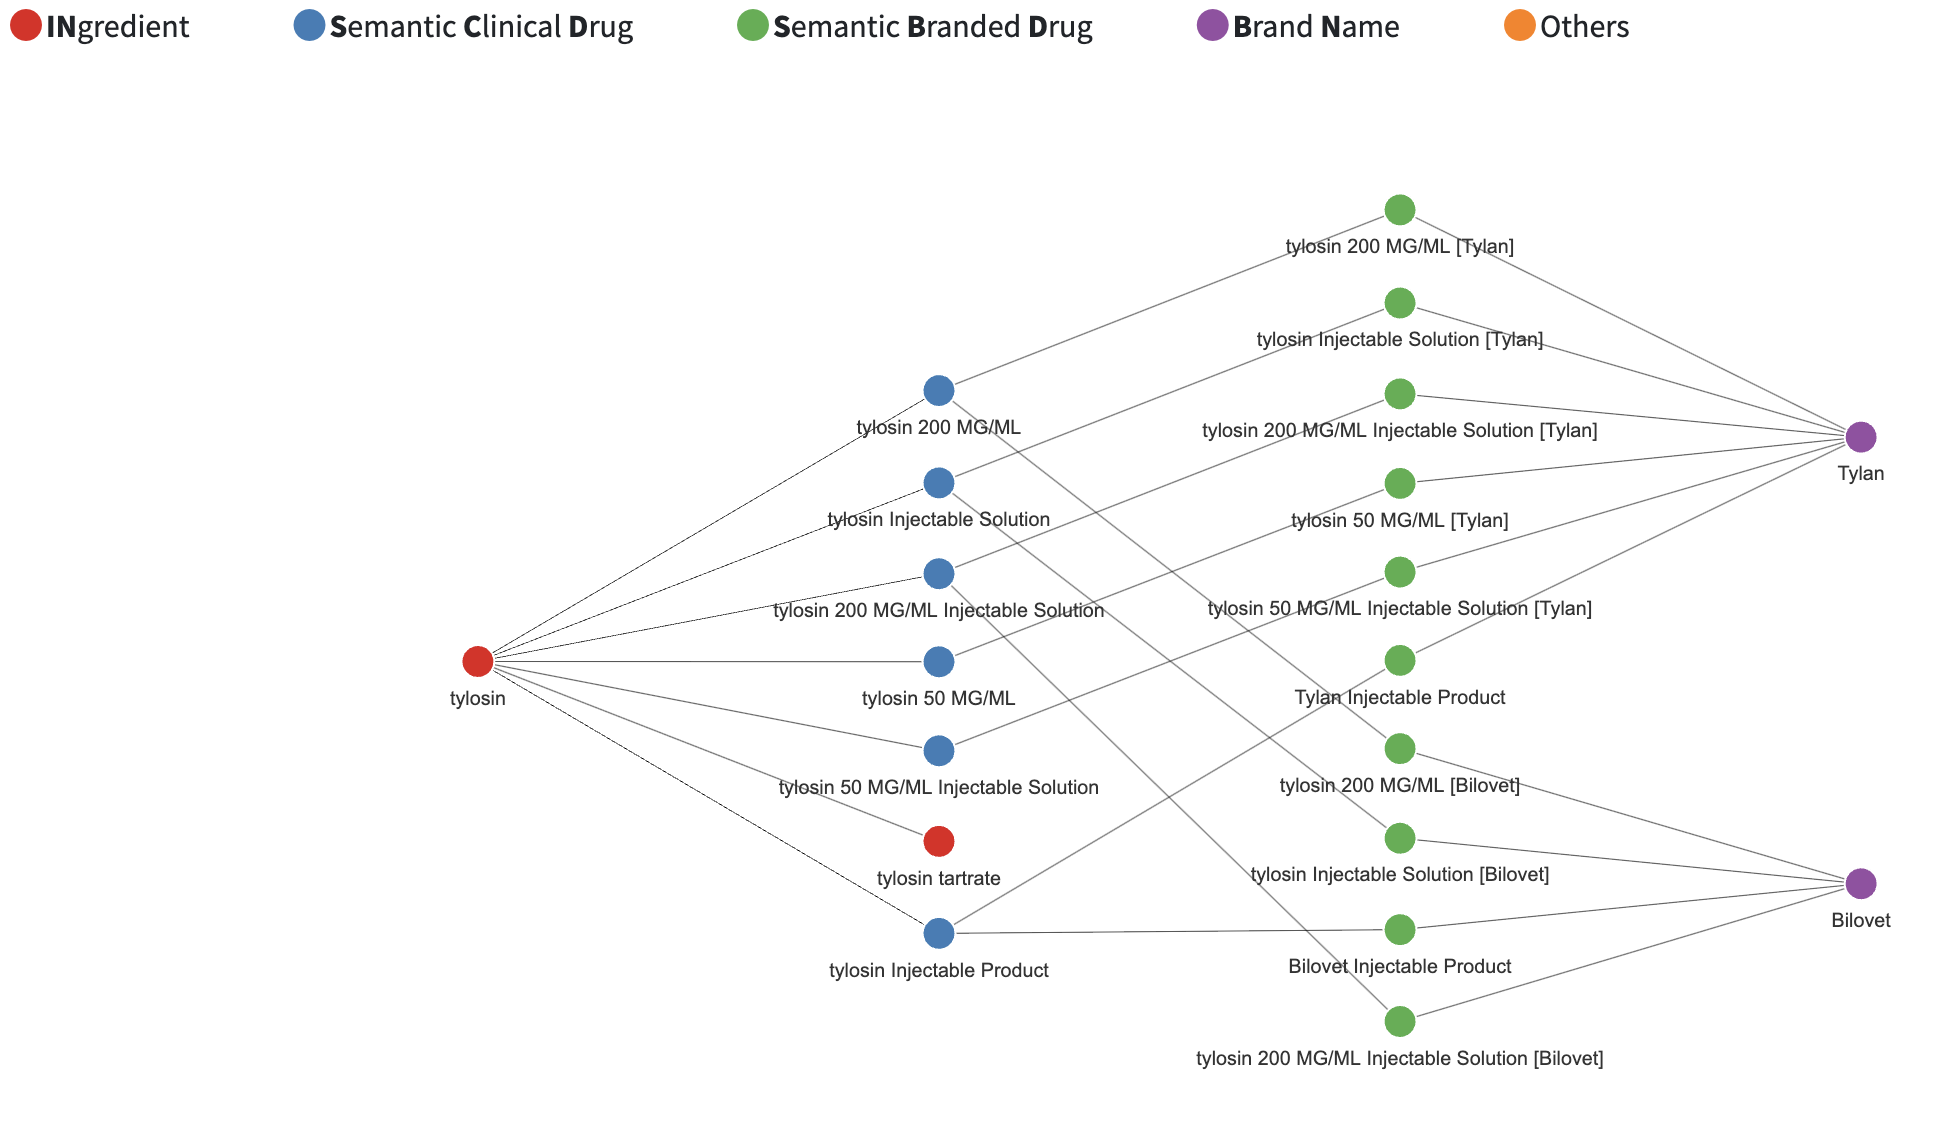

In [6]:
base_directory = os.path.dirname(os.getcwd())

medication_cleaned_rawdata = os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata', "Medication")
medication_files = os.listdir(medication_cleaned_rawdata)
sample_medication_file = os.path.join(medication_cleaned_rawdata, medication_files[0])
sample_medication = pd.read_csv(sample_medication_file, dtype=str)
display(sample_medication.head())


medication_rollup_file = os.path.join(base_directory, 'scripts', 'rollup_mappings',"NDC_to_RxNorm.csv")
medication_to_rxnorm = pd.read_csv(medication_rollup_file, dtype=str)
display(medication_to_rxnorm.head())

,subject_id,date,code,coding_system
0,10000032,2180-05-08,51079007320,NDC
1,10000032,2180-05-07,00487980125,NDC
2,10000032,2180-05-07,51079007220,NDC
3,10000032,2180-05-07,00245004101,NDC
4,10000032,2180-05-07,0,NDC


,code,RxNorm,coding_system
0,00295117904,5499,NDC
1,00295117916,5499,NDC
2,00363026816,5499,NDC
3,00363026832,5499,NDC
4,00363087143,5499,NDC


In [7]:
# Processing prescription.
config={
    "patient_id":"subject_id",
    "parent_column":"RxNorm", # The parent column should be exactly as the parent column in the rollup mapping file
    "child_column":"code",
    "date":"date",
    "rollup_mapping":medication_to_rxnorm
}

rollup_data_by_batch(
    config ,
    os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata','Medication')
)

,subject_id,date,RxNorm
0,10000826,2146-12-06,7052
1,10000826,2146-12-06,6470
2,10000826,2146-12-05,5224
3,10000826,2146-12-07,82003
4,10000826,2146-12-07,7804
...,...,...,...
2046427,19999565,2185-06-04,1728802
2046428,19999565,2185-06-04,161_7804
2046429,19999565,2185-06-04,67108
2046430,19999565,2185-06-04,3423


Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [01:03<00:00,  7.96s/batch]


,code,counts
0,0,188786
63,49281041688,19499
40,19515090941,11213
86,66689036430,9253
80,63323029766,4491
...,...,...
18,08881200441,2
32,16590023730,1
88,68258912401,1
39,19515089241,1


### Laboratory Data

In MIMIC, lab observations are stored in the `labevents.csv` file. Lab observations in U.S. EHR systems are typically recorded as LOINC codes. The latest MIMIC dataset does not include LOINC codes, and the proportion of MIMIC-IV 3.1 lab tests that can be mapped to LOINC is currently very small. However, we will demonstrate the process of rolling up lab tests using LOINC codes as an example.

Additionally, we do not always roll up LOINC codes. Sometimes, we prefer to retain the LOINC codes at their original level and use the recorded lab values directly in our analysis pipeline.

Below is an example of multiple lab tests measuring creatinine. Here, we roll up all the lab tests to the LOINC component level (the specific item being measured), which here is creatinine.

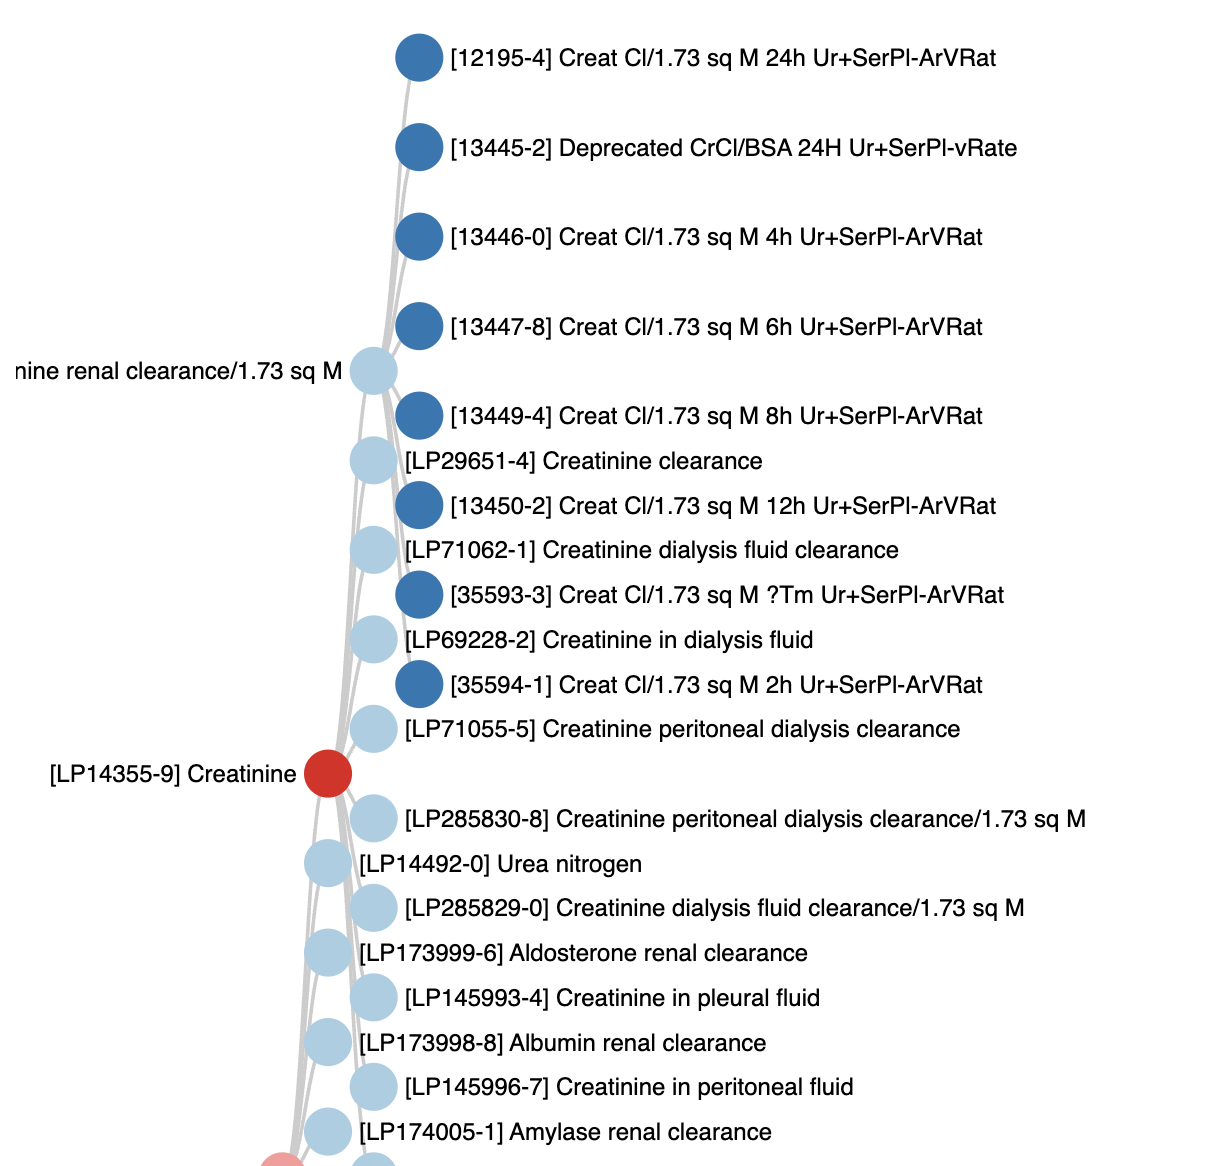


In [8]:
base_directory = os.path.dirname(os.getcwd())

labs_cleaned_rawdata = os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata',"Labs")
lab_files = os.listdir(labs_cleaned_rawdata)
sample_lab_file= os.path.join(labs_cleaned_rawdata, lab_files[0])
sample_lab = pd.read_csv(sample_lab_file, dtype=str)
display(sample_lab.head())

,subject_id,date,code,coding_system
0,10000032,2180-03-23,50931,ITEMID
1,10000032,2180-03-23,51071,ITEMID
2,10000032,2180-03-23,51074,ITEMID
3,10000032,2180-03-23,51075,ITEMID
4,10000032,2180-03-23,51079,ITEMID


If you notice the coding_system, it's ITEMID which is not a standard coding system. MIMIC-IV provides a mapping from ITEMID to LOINC code. We will rollup LOINC codes to LOINC components. Similarly, in real world EHR data, you will have to source/merge data from different sources 

In [10]:
itemid_to_loinc_file = os.path.join(base_directory, 'scripts', 'meta_files',"lab_itemid_to_loinc.csv")
itemid_to_loinc = pd.read_csv(itemid_to_loinc_file, dtype=str)
itemid_to_loinc.dropna(subset=['loinc'],inplace=True)
itemid_to_loinc.head(5)

,itemid,label,fluid,category,valueuom,loinc,loinc_version,notes
5,50903,Cholesterol Ratio (Total/HDL),Blood,Chemistry,Ratio,9830-1,2.71,Mass ratio is more common than molar ratio in the US
6,50911,"Creatine Kinase, MB Isoenzyme",Blood,Chemistry,ng/mL,13969-1,2.71,This is the LOINC code US labs use
8,50937,Hepatitis A Virus Antibody,Blood,Chemistry,N/A|Pos/Neg,13951-9,2.71,More specific method
10,50941,Hepatitis B Surface Antigen,Blood,Chemistry,NaN,5196-1,2.71,More specific method
11,50942,Hepatitis B Virus Core Antibody,Blood,Chemistry,NaN,13952-7,2.71,More specific method


In [12]:

loinc_hierarchy_file = os.path.join(base_directory, 'scripts', 'meta_files',"LOINC_Hierarchy_v2.73_version4.csv")
loinc_hierarchy =  pd.read_csv(loinc_hierarchy_file, dtype=str)

# Select relevant columns and rename for clarity
loinc_rollup = loinc_hierarchy[['LOINC', 'PARENT_LOINC']].rename(columns={'LOINC': 'loinc', 'PARENT_LOINC': 'LoincComponent'})
itemid_to_loinc = itemid_to_loinc[['itemid', 'loinc']]

# Merge the mappings to associate item IDs with LOINC components
lab_to_loinc_component = pd.merge(itemid_to_loinc, loinc_rollup, on="loinc", how="left")

#  rename columns to match the lab data columns
lab_to_loinc_component = lab_to_loinc_component.rename(columns={"itemid": "code"})
lab_to_loinc_component['coding_system'] = 'ITEMID'
lab_to_loinc_component = lab_to_loinc_component[['code', 'LoincComponent', 'coding_system']]

# Display the first few rows of the resulting DataFrame
display(lab_to_loinc_component.head(5))

,code,LoincComponent,coding_system
0,50903,LP307370-9,ITEMID
1,50911,LP15513-2,ITEMID
2,50937,LP38316-3,ITEMID
3,50941,LP38331-2,ITEMID
4,50942,LP38323-9,ITEMID


In [13]:
# Processing prescription.
config={
    "patient_id":"subject_id",
    "parent_column":"LoincComponent", # The parent column should be exactly as the parent column in the rollup mapping file
    "child_column":"code",
    "date":"date",
    "rollup_mapping":lab_to_loinc_component
}

rollup_data_by_batch(
    config,
    os.path.join(base_directory, 'processed_data', 'step3_cleaned_rawdata','Labs')
)

,subject_id,date,LoincComponent
5,10000161,2163-05-03,LP15957-1
7,10000161,2163-05-03,LP14328-6
8,10000161,2163-05-03,LP14539-8
12,10000161,2163-05-03,LP14540-6
16,10000161,2163-05-03,LP14313-8
...,...,...,...
16452202,19999565,2185-06-04,LP14267-6
16452209,19999565,2185-06-04,LP15957-1
16452210,19999565,2185-06-04,LP14082-9
16452233,19999565,2185-06-04,LP14635-4


Processing batches: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [06:18<00:00, 47.34s/batch]


,code,counts
362,51221,218775
402,51265,218717
363,51222,218647
433,51301,218646
389,51250,218644
...,...,...
787,52055,1
783,52032,1
564,51459,1
747,51927,1


After Step 4, you will have the following files in your workspace:

```bash
EHR_TUTORIAL_WORKSPACE/
└── processed_data/
    ├── step4_rolledup_finaldata/
    │   ├── Diagnoses/
    │   │   ├── rolledup_batch1.csv
    │   │   ├── rolledup_batch2.csv
    │   │   ├── rolledup_batch3.csv
    │   │   ├── rolledup_batch4.csv
    │   │   ├── rolledup_batch5.csv
    │   │   ├── rolledup_batch6.csv
    │   │   ├── rolledup_batch7.csv
    │   │   └── rolledup_batch8.csv
    │   ├── Labs/
    │   │   ├── rolledup_batch1.csv
    │   │   ├── rolledup_batch2.csv
    │   │   ├── rolledup_batch3.csv
    │   │   ├── rolledup_batch4.csv
    │   │   ├── rolledup_batch5.csv
    │   │   ├── rolledup_batch6.csv
    │   │   ├── rolledup_batch7.csv
    │   │   └── rolledup_batch8.csv
    │   ├── Medication/
    │   │   ├── rolledup_batch1.csv
    │   │   ├── rolledup_batch2.csv
    │   │   ├── rolledup_batch3.csv
    │   │   ├── rolledup_batch4.csv
    │   │   ├── rolledup_batch5.csv
    │   │   ├── rolledup_batch6.csv
    │   │   ├── rolledup_batch7.csv
    │   │   └── rolledup_batch8.csv
    │   └── Procedures/
    │       ├── rolledup_batch1.csv
    │       ├── rolledup_batch2.csv
    │       ├── rolledup_batch3.csv
    │       ├── rolledup_batch4.csv
    │       ├── rolledup_batch5.csv
    │       ├── rolledup_batch6.csv
    │       ├── rolledup_batch7.csv
    │       └── rolledup_batch8.csv
    └── step4_rolledup_intermediatedata/
        ├── Diagnoses/
        │   ├── intermediate_batch1.csv
        │   ├── intermediate_batch2.csv
        │   ├── intermediate_batch3.csv
        │   ├── intermediate_batch4.csv
        │   ├── intermediate_batch5.csv
        │   ├── intermediate_batch6.csv
        │   ├── intermediate_batch7.csv
        │   └── intermediate_batch8.csv
        ├── Labs/
        │   ├── intermediate_batch1.csv
        │   ├── intermediate_batch2.csv
        │   ├── intermediate_batch3.csv
        │   ├── intermediate_batch4.csv
        │   ├── intermediate_batch5.csv
        │   ├── intermediate_batch6.csv
        │   ├── intermediate_batch7.csv
        │   └── intermediate_batch8.csv
        ├── Medication/
        │   ├── intermediate_batch1.csv
        │   ├── intermediate_batch2.csv
        │   ├── intermediate_batch3.csv
        │   ├── intermediate_batch4.csv
        │   ├── intermediate_batch5.csv
        │   ├── intermediate_batch6.csv
        │   ├── intermediate_batch7.csv
        │   └── intermediate_batch8.csv
        └── Procedures/
            ├── intermediate_batch1.csv
            ├── intermediate_batch2.csv
            ├── intermediate_batch3.csv
            ├── intermediate_batch4.csv
            ├── intermediate_batch5.csv
            ├── intermediate_batch6.csv
            ├── intermediate_batch7.csv
            └── intermediate_batch8.csv
```